In [69]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

# unit test utilities
def is_approximately_equal(test,target,eps=1e-2):
    return np.mean(np.fabs(np.array(test) - np.array(target)))<eps

def assert_test_equality(test, target):
    assert is_approximately_equal(test, target), 'Expected:\n %s \nbut got:\n %s'%(target, test)

# Quadratic Programming and Large Margin Classifiers

## Quadratic programming

At the heart of the dual formulation of the large margin classifier (LMC) is the quadratic programme with constraints.  For example, for the hard LMC the dual Lagrange function to be *maximised* is:
\begin{align*}
          \newcommand{\balpha}{\mathbf{\alpha}}
          \newcommand{\bx}{\mathbf{x}}
        \max_{\balpha} & ~~ \sum_n \alpha_n - \frac{1}{2} \sum_{n,m}t_n t_m
                         \alpha_n\alpha_m \langle\bx_n, \bx_m\rangle\\
        \text{such that   }\quad & \alpha_n \ge 0, \quad \sum_n \alpha_n t_n = 0
\end{align*}
      
There are a number of quadratic optimization libraries that you could use, one is [cvxopt](http://cvxopt.org/).  

Install the library via:

`pip install cvxopt`

or

`conda install -c conda-forge cvxopt`

Then you should be able to import the module with:

    import cvxopt

## `cvxopt` example

Here is an example of solving a constrained quadratic program (QP) with `cvxopt`. 

The standard form for a QP in `cvxopt` notation is:

\begin{align*}
        \min_{x}  \tfrac{1}{2} x^T P x &+ q^T x \\
        \text{such that   }\quad  Gx &\preceq h\\
        Ax & = b
\end{align*}
where $Gx \preceq h$ means that the inequality is taken element-wise for each row of $Gx$ and $h$.

In `cvxopt` the QP is defined by the parameters $P, q, G, h, A$ and $b$.  The matrix $P$ and the vector $q$ must be specified, but the others are optional.   Note that all optimisations must be manipulated to be of this form.  In particular, note that you will want to *maximise* the Lagrangian dual $g(\mathbf{\alpha})$, so you will have to write the maximisation as the minimisation of $-g(\mathbf{\alpha})$.

### Example

Consider this example:

\begin{align*}
        \min_{x,y}  \tfrac{1}{2} x^2 + & 3x + 4y\\
        \text{such that   }\quad x, y & \ge 0\\
        x + 3y & \ge 15\\
        2x + 5y & \le 100\\
        3x + 4y & \le 80
\end{align*}

Let's evaluate the objective function on a grid covering the range $[-5, 20] \times [-5, 20]$ and so plot contours of the objective function.  

We are going to augment the plot with lines showing the inequalities and so, by eye, we will find the minimum of the objective function.

In [70]:
import cvxopt

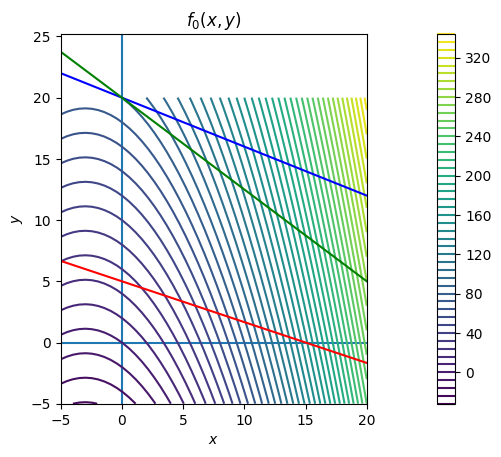

In [71]:
def f0(x, y):
    """Evaluate the objective function"""
    return x * x / 2 + 3 * x + 4 * y

x = np.linspace(-5, 20, 50)
y = np.linspace(-5, 20, 50)
X, Y = np.meshgrid(x, y)
F0 = f0(X, Y)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'$f_0(x, y)$')
plt.axhline(0.0)
plt.axvline(0.0)
plt.contour(X, Y, F0, 50)
plt.plot(x, 5 - x / 3, 'r')
plt.plot(x, (100 - 2 * x) / 5, 'b')
plt.plot(x, (80 - 3 * x) / 4, 'g')
plt.colorbar()
plt.axis('scaled')
plt.show()

The problem can be written in standard form as:

\begin{align*}
  \min_{x, y} \tfrac{1}{2}
  \begin{bmatrix}
    x \\ y
  \end{bmatrix}^T
  \begin{bmatrix}
    1 & 0\\
    0 & 0
  \end{bmatrix}
  \begin{bmatrix}
    x \\ y
  \end{bmatrix}
  +
   \begin{bmatrix}
    3 \\ 4
  \end{bmatrix}^T
 \begin{bmatrix}
    x \\ y
  \end{bmatrix}\\
  \begin{bmatrix}
    -1 & 0\\
    0 & -1\\
    -1 & -3\\
    2 & 5\\
    3 & 4
  \end{bmatrix}
  \begin{bmatrix}
    x \\ y
  \end{bmatrix}  
  \preceq
  \begin{bmatrix}
    0 \\ 0 \\ -15 \\ 100 \\ 80
  \end{bmatrix}
\end{align*}

Note that all the inequality constraints have been gathered into the matrix $G$ and that since there are no equality constraints $A$ and $b$ do not need to be specified. Note that even though $y^2$ did not appear in the original objective, we had to include it with zero coefficients in P because the solver parameters must be defined using the full set of variables.  Even if certain variables only appear in constraints, they will still need to be expressed with zero coefficients in the objective parameters, and *vice versa*.

Matrices specifying the QP to `cxvopt` are defined using the `cvxopt` matrices.  Since you will be using `numpy` arrays to store the data for your LMC and SVM, we will define the `cvxopt` matrices via `numpy` arrays as follows.

In [72]:
from cvxopt import matrix

P = matrix(np.diag([1,0]), tc='d') 
q = matrix(np.array([3,4]).reshape(-1,1), tc='d')
G = matrix(np.array([[-1,0],[0,-1],[-1,-3],[2,5],[3,4]]), tc='d')
h = matrix(np.array([0,0,-15,100,80]).reshape(-1,1), tc='d')

The `tc='d'` argument ensures that the matrices are floating point numbers rather than integers (`tc` stands for "typecode"). Now at last, we can solve the QP:

In [73]:
from cvxopt import solvers
sol = solvers.qp(P, q, G, h)

Information about the solution can be found from the `sol` dictionary

In [74]:
print('The solution is\n', sol['x'])
print('The objective is', sol['primal objective'])

The solution is
 [ 7.13e-11]
[ 5.00e+00]

The objective is 20.00000000061731


More information from the various key-value pairs in the dictionary.  See the [`cxvopt` documentation](http://cvxopt.org/userguide/index.html) for more information on what these mean.

In [75]:
for k, v in sol.items():
    print(k, v)

x [ 7.13e-11]
[ 5.00e+00]

y 
s [ 7.13e-11]
[ 5.00e+00]
[ 3.74e-10]
[ 7.50e+01]
[ 6.00e+01]

z [ 1.67e+00]
[ 2.35e-12]
[ 1.33e+00]
[ 1.51e-12]
[ 2.28e-12]

status optimal
gap 8.788553223174217e-10
relative gap 4.394276611644573e-11
primal objective 20.00000000061731
dual objective 19.999999999738456
primal infeasibility 8.928408056441743e-17
dual infeasibility 4.9006209392764185e-17
primal slack 7.131816409146226e-11
dual slack 1.5069511036060204e-12
iterations 10


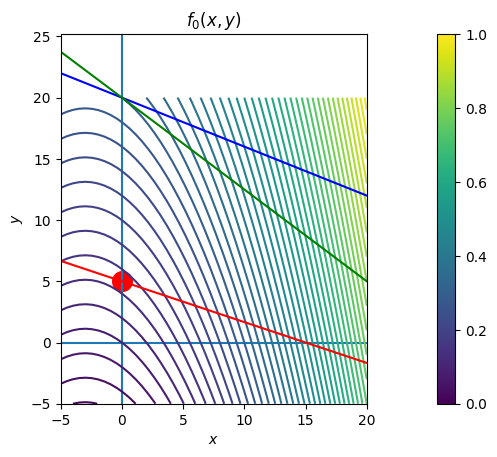

[ 7.13e-11]
[ 5.00e+00]
 20.00000000061731


In [76]:
def f0(x, y):
    """Evaluate the objective function"""
    return x * x / 2 + 3 * x + 4 * y

x = np.linspace(-5, 20, 50)
y = np.linspace(-5, 20, 50)
X, Y = np.meshgrid(x, y)
F0 = f0(X, Y)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'$f_0(x, y)$')
plt.axhline(0.0)
plt.axvline(0.0)
plt.contour(X, Y, F0, 50)
plt.plot(x, 5 - x / 3, 'r')
plt.plot(x, (100 - 2 * x) / 5, 'b')
plt.plot(x, (80 - 3 * x) / 4, 'g')
s = np.array(sol['x']).T
plt.scatter(s[:,0],s[:,1],s=200,c='r')
plt.colorbar()
plt.axis('scaled')
plt.show()
print(sol['x'],sol['primal objective'])

---

## Hard Large Margin Classifier

Let's now use `cxvopt` to solve the large margin problem.

In [77]:
def plot(X, y, support_vectors=None, predict_func=None):
    cmap='bwr'
    res = 100
    x_min, x_max = X[:, 0].min(), X[:, 0].max()
    y_min, y_max = X[:, 1].min(), X[:, 1].max()
    delta = max((x_max-x_min)/5, (y_max-y_min)/5)
    x_min -= delta
    y_min -= delta
    x_max += delta
    y_max += delta
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, res),np.linspace(y_min, y_max, res))
    if predict_func is None:
        Z = np.ones(xx.shape)*.5
    else:
        Z = predict_func(np.hstack([xx.reshape(-1,1), yy.reshape(-1,1)]))
        if Z.ndim == 1:
            Z = Z.reshape(xx.shape)
        else:
            Z = Z[:,-1].reshape(xx.shape)
    if support_vectors is None:
        edge_colors = 'w'
        sizes = 50
    else:
        edge_colors = ['k' if s else 'w' for s in support_vectors]
        sizes = [100 if s else 50 for s in support_vectors]
    plt.figure(figsize=(5,5))
    plt.contourf(xx, yy, Z, levels=20, cmap=cmap, alpha=.5)
    plt.scatter(X[:,0],X[:,1], c=y, s=sizes, edgecolors=edge_colors, cmap=cmap)
    plt.grid()
    plt.axis('equal')
    plt.show()

### Re-writing the problem in an appropriate format

We need to match the solver's API which, according to the documentation is of the form:

\begin{aligned}
    & \min \frac{1}{2} x^TPx + q^Tx
    \\
     s.t. \ & \ Gx \leq h 
    \\
    & \ Ax = b
\end{aligned}

Recall that the dual problem is expressed as:

\begin{aligned}
\max_{\alpha} \sum_i^m \alpha_i - \frac{1}{2} \sum_{i,j}^m y^{(i)}y^{(j)} \alpha_i \alpha_j <x^{(i)}, x^{(j)}>
\end{aligned}

Let $\mathbf{H}$ be a matrix such that $H_{i,j} = y^{(i)}y^{(j)} <x^{(i)} x^{(j)}>$, then the optimization becomes:

\begin{aligned}
    & \max_{\alpha} \sum_i^m \alpha_i  - \frac{1}{2}  \alpha^T \mathbf{H}  \alpha
    \\
     s.t. & \ \alpha_i \geq 0 
    \\
    &  \ \sum_i^m \alpha_i y^{(i)} = 0  
\end{aligned}

We convert the sums into vector form and multiply both the objective and the constraint by −1 which turns this into a minimization problem and reverses the inequality

\begin{aligned}
    & \min_{\alpha}  \frac{1}{2}  \alpha^T \mathbf{H}  \alpha - 1^T \alpha
    \\
    & s.t. \ - \alpha_i \leq 0 
    \\
    & s.t. \ y^T \alpha = 0 
\end{aligned}

We are now ready to convert our numpy arrays into the cvxopt format, using the same notation as in the documentation this gives

* $P:=H$ a matrix of size $m×m$
* $q:=−\vec{1}$  a vector of size $m×1$
* $G:=−diag[1]$ a diagonal matrix of -1s of size $m×m$
* $h:=\vec{0}$ a vector of zeros of size $m×1$
* $A:=y^T$ the label vector of size $1×m$
* $b:=0$ a scalar

Note that in the simple example of $m=2$ the matrix $G$ and vector $h$ which define the constraint are 

$$G = \begin{bmatrix} -1 & 0 \\ 0 & -1 \end{bmatrix} \ \ \text{and} \ \ h = \begin{bmatrix} 0 \\ 0  \end{bmatrix}$$

### Computing the matrix $\mathbf{H}$ in vectorized form

Consider the simple example with 2 input samples $\{x^{(1)}, x^{(2)}\} \in \mathbb{R}^2$ which are two dimensional vectors. i.e. $x^{(1)} = (x_1^{(1)} , x_2^{(1)})^T$

$$X = \begin{bmatrix} x_1^{(1)} & x_2^{(1)} \\ x_1^{(2)} & x_2^{(2)} \end{bmatrix} \ \ \text{and} \ \ y = \begin{bmatrix} y^{(1)}  \\ y^{(2)} \end{bmatrix}$$

We now proceed to creating a new matrix $X′$ where each input sample $x$ is multiplied by the corresponding output label y. 

$$X' = \begin{bmatrix} x^{(1)}_1 y^{(1)} & x^{(1)}_2y^{(1)} \\
x^{(2)}_1y^{(2)} & x^{(2)}_2y^{(2)} \end{bmatrix}$$

Finally we take the **matrix multiplication** of $X′$ and its transpose giving $H=X′X′^T$

$$H = X' @ X'^T = \begin{bmatrix} x^{(1)}_1 y^{(1)} & x^{(1)}_2y^{(1)} \\
x^{(2)}_1y^{(2)} & x^{(2)}_2y^{(2)} \end{bmatrix} \begin{bmatrix} x^{(1)}_1 y^{(1)} & x^{(2)}_1 y^{(2)}  \\
x^{(1)}_2y^{(1)} & x^{(2)}_2y^{(2)} \end{bmatrix}$$

$$H = \begin{bmatrix}  x^{(1)}_1 x^{(1)}_1y^{(1)}y^{(1)} + x^{(1)}_2x^{(1)}_2y^{(1)}y^{(1)} & x^{(1)}_1 x^{(2)}_1y^{(1)}y^{(2)} + x^{(1)}_2x^{(2)}_2y^{(1)}y^{(2)} \\ x^{(2)}_1 x^{(1)}_1y^{(2)}y^{(1)} + x^{(2)}_2x^{(1)}_2y^{(2)}y^{(1)} & x^{(2)}_1 x^{(2)}_1y^{(2)}y^{(2)} + x^{(2)}_2x^{(2)}_2y^{(2)}y^{(2)} \end{bmatrix}$$

## Question 1

Make the function `X_prime = make_X_prime(X,t)` to compute $X′$

In [78]:
def make_X_prime(X,t):
    t_1 = np.array([t,t])
    return np.multiply(X,t_1.T)

In [79]:
# This cell is reserved for the unit tests. Do not consider this cell. 
### BEGIN TESTS
X = np.array([[1,2],[3,4]])
t = np.array([5,6])
Xp = make_X_prime(X,t)
Xp_target = np.array([[ 5., 10.],[18., 24.]])
assert_test_equality(Xp, Xp_target)
### END TESTS

## Question 2

Make the function `H = make_H(X,t)` to compute $H$

In [80]:
def make_H(X,t):
    X_prime = make_X_prime(X,t)
    return np.dot(X_prime,X_prime.T)

In [81]:
# This cell is reserved for the unit tests. Do not consider this cell. 
### BEGIN TESTS
X = np.array([[1,2],[3,4]])
t = np.array([5,6])
H = make_H(X,t)
H_target = np.array([[125., 330.],[330., 900.]])
assert_test_equality(H, H_target)
### END TESTS

## Question 3

Make the function `P, q, G, h, A, b = setup_optimization(X,t)` to compute the necessary matrices to define the optimization problem for the cvxopt solver.

**Note:** you have to convert Numpy matrices to the `matrix` object from the cvxopt library. 

In [98]:
from cvxopt import matrix
def setup_optimization(X,t):
    H = make_H(X,t)
    t_1 = np.array([t,t])
    m = H.shape[0]
    P = matrix(H, tc='d') 
    q = matrix(np.ones((m,1))*-1, tc='d')
    h = matrix(np.zeros((m,1)), tc='d')
    A = matrix(t.reshape(1,-1), tc='d')
    G = matrix(np.diag([1 for i in range(m)])*-1, tc='d')
    b= matrix(np.zeros(1))
    return P,q,G,h,A,b

In [99]:
# This cell is reserved for the unit tests. Do not consider this cell. 
### BEGIN TESTS
X = np.array([[1,-1],[1,-1]])
t = np.array([1,-1])
P, q, G, h, A, b = setup_optimization(X,t)
P_target = np.array([[ 2., -2.],[-2.,  2.]])
assert_test_equality(P, P_target)

q_target = np.array([[-1.],[-1.]])
assert_test_equality(q, q_target)

G_target = np.array([[-1., -0.],[-0., -1.]])
assert_test_equality(G, G_target)

h_target = np.array([[0.],[0.]])
assert_test_equality(h, h_target)

A_target = np.array([[ 1., -1.]])
assert_test_equality(A, A_target)

b_target = np.array([[0.]])
assert_test_equality(b, b_target)
### END TESTS

## Question 4

Make the function `support_vectors,support_targets,support_alphas, support_ids = compute_support_vectors(X,t,alphas)` to compute:
- `support_vectors` the support vectors
- `support_targets` the target vector associated to the support vectors
- `support_alphas` the vector of the dual variables $\alpha_i$ associated to the support vectors
- `support_ids` a boolean vector that indicates if a position is associated to a support vector (w.r.t. the original data matrix) (i.e. if the first instance is a support vector and the second one it is not, then `support_ids` = [True, False])

In [106]:
def compute_support_vectors(X,t,alphas):
    support_ids = [True if alphas[i]>0 else False for i in range(len(alphas))]
    support_vectors = [X[i] for i in range(len(X)) if alphas[i]>0]
    support_alphas = [alphas[i] for i in range(len(alphas)) if alphas[i]>0]
    support_targets = [[t[i]] for i in range(len(t)) if alphas[i]>0] 
    return np.array(support_vectors),np.array(support_targets),np.array(support_alphas),np.array(support_ids)   

In [107]:
# This cell is reserved for the unit tests. Do not consider this cell. 
### BEGIN TESTS
X = np.array([[1,-1],[1,-1],[0,0]])
t = np.array([1,-1,1])
alphas = np.array([1,1,0])
support_vectors,support_targets,support_alphas, support_ids = compute_support_vectors(X,t,alphas)
support_vectors_target = [[ 1, -1],[ 1, -1]]
assert_test_equality(support_vectors, support_vectors_target)
support_targets_target = [[ 1.],[-1.]]
assert_test_equality(support_targets, support_targets_target)
support_alphas_target = [1, 1]
assert_test_equality(support_alphas, support_alphas_target)
support_ids_target = [ True,  True, False]
assert np.all(support_ids == support_ids_target)
### END TESTS

## Note

You can now use the following code to observe the properties of the hard large margin solution.

In [102]:
from cvxopt import matrix
from cvxopt import solvers

def train_lmc(X, t):
    P, q, G, h, A, b = setup_optimization(X,t)

    #Setting solver parameters (change default to decrease tolerance) 
    solvers.options['show_progress'] = False
    solvers.options['abstol'] = 1e-10
    solvers.options['reltol'] = 1e-10
    solvers.options['feastol'] = 1e-10

    #Run solver
    solution_dict = solvers.qp(P, q, G, h, A, b)
    alphas = np.array(solution_dict['x'])
    
    support_vectors,support_targets,support_alphas, support_ids = compute_support_vectors(X,t,alphas)

    return support_vectors,support_targets,support_alphas, support_ids

def compute_hyperplane(support_vectors, support_targets, support_alphas, support_ids):
    w = ((support_targets * support_alphas).T @ support_vectors).reshape(-1,1)
    b = np.mean(support_targets - np.dot(support_vectors, w))
    return w,b

def score_lmc(X_test, model):
    w,b = compute_hyperplane(*model)
    scores = np.dot(X_test, w) + b
    return scores.flatten()

def test_lmc(X_test, model):
    preds = np.sign(score_lmc(X_test, model)).astype(int)
    return preds.flatten()

In [103]:
# wrap the code to make a classifier object following the scikit style

class MyHardLargeMarginClassfier(object):
    def __init__(self):
        self.support_vectors = None
        self.support_targets = None
        self.support_alphas = None
        self.support_ids = None
    
    def fit(self, X_train, y_train):
        self.support_vectors, self.support_targets,self.support_alphas,self.support_ids=train_lmc(X_train, y_train)
        return self
    
    def predict(self, X_test):
        model = (self.support_vectors, self.support_targets,self.support_alphas, self.support_ids)
        return test_lmc(X_test, model)
        
    def decision_function(self, X_test):
        model = (self.support_vectors, self.support_targets,self.support_alphas, self.support_ids)
        return score_lmc(X_test, model)
    
    def predict_proba(self, X_test):
        model = (self.support_vectors, self.support_targets,self.support_alphas, self.support_ids)
        scores = score_lmc(X_test, model)
        probs = 1 / (1 + np.exp(-scores))
        return probs

#### Toy Dataset

We consider two simple cases: one that admits a linear separation and one that does not. 

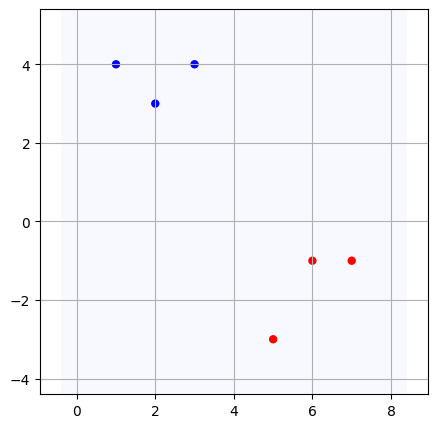

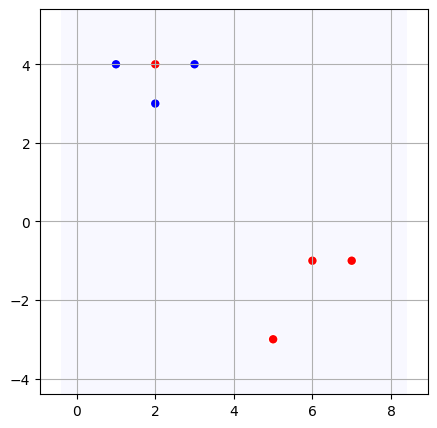

In [104]:
#Data
x_neg = np.array([[3,4],[1,4],[2,3]])
y_neg = np.array([-1,-1,-1])
x_pos = np.array([[6,-1],[7,-1],[5,-3]])
y_pos = np.array([1,1,1])
X_sep = np.vstack((x_pos, x_neg))
t_sep = np.concatenate((y_pos, y_neg))

x_neg = np.array([[3,4],[1,4],[2,3]])
y_neg = np.array([-1,-1,-1])
x_pos = np.array([[6,-1],[7,-1],[5,-3],[2,4]])
y_pos = np.array([1,1,1,1])
X_non_sep = np.vstack((x_pos, x_neg))
t_non_sep = np.concatenate((y_pos, y_neg))

plot(X_sep,t_sep)
plot(X_non_sep,t_non_sep)

### Evaluation

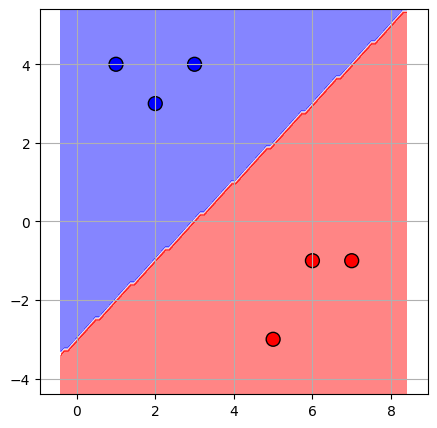

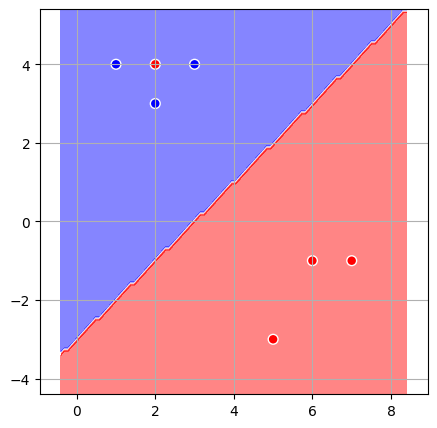

In [108]:
est = MyHardLargeMarginClassfier().fit(X_sep, t_sep)
plot(X_sep,t_sep, support_vectors=est.support_ids, predict_func=est.predict)
plot(X_non_sep,t_non_sep, predict_func=est.predict)

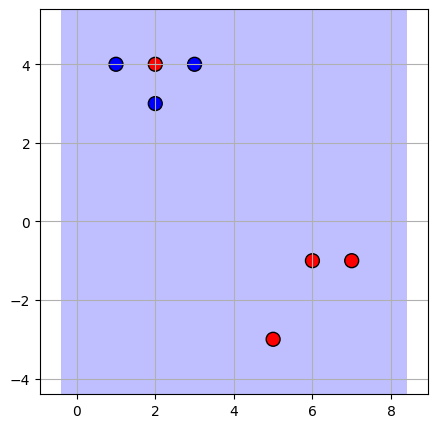

In [109]:
# if we train on the non seperable case we cannot find a solution
est = MyHardLargeMarginClassfier().fit(X_non_sep, t_non_sep)
plot(X_non_sep,t_non_sep, support_vectors=est.support_ids, predict_func=est.predict)

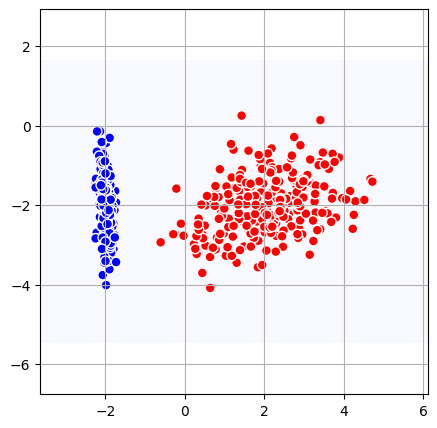

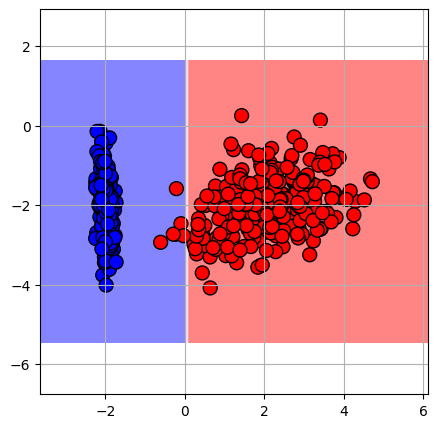

In [110]:
# prepare a classification data set
from sklearn.datasets import make_classification
X,y = make_classification(n_samples=500, n_features=2, n_informative=2, n_redundant=0, n_repeated=0, n_classes=2, n_clusters_per_class=1, weights=None, flip_y=0.0, class_sep=2.0)
y[y==0]=-1
plot(X,y)
est = MyHardLargeMarginClassfier().fit(X, y)
plot(X,y,support_vectors=est.support_ids, predict_func=est.predict)

### Soft Large Margin Classifier

Of course, most interesting data sets are not linearly separable.  Using your `lmc` function as a basis, write a new function:

    sv, score = lsvm(X, t, C, Xtest)

that implements a soft large margin classifier. The additional parameter `C` should specify the relative weight given to the emperical error versus the regularisation term.

For the softmax margin SVM, recall that the optimization problem can be expressed as

\begin{aligned}
    & \max_{\alpha} \sum_i^m \alpha_i  - \frac{1}{2}  \alpha^T \mathbf{H}  \alpha
    \\
     s.t. \ \ & 0 \leq \alpha_i \leq C 
    \\
    &  \ \sum_i^m \alpha_i y^{(i)} = 0  
\end{aligned}

which can be written in standard form as

\begin{aligned}
    & \min_{\alpha}  \frac{1}{2}  \alpha^T \mathbf{H}  \alpha - 1^T \alpha
    \\
     s.t. & \ - \alpha_i \leq 0 
    \\
     & \alpha_i \leq C
     \\
     &\ y^T \alpha = 0  
\end{aligned}

This is almost the same problem as previously, except for the additional inequality constraint on $\alpha$. We translate this new constraint into standard form by concatenating below matrix $G$ a diagonal matrix of 1s of size $m \times m$. Similarly for the vector $h$ to which the value of $C$ is added $m$ times.

Note that in the simple example of $m=2$ the matrix $G$ and vector $h$ which define the constraint are

$$G = \begin{bmatrix} -1 & 0 \\ 0 & -1 \\ 1 & 0 \\ 0 & 1\end{bmatrix} \ \ \text{and} \ \ h = \begin{bmatrix} 0 \\ 0 \\ C \\ C \end{bmatrix}$$

## Question 5

Make the function `P, q, G, h, A, b = setup_optimization_soft(X,t,C)` to to compute the necessary matrices to define the soft margin optimization problem for the cvxopt solver.

In [111]:
def setup_optimization_soft(X,t,C):
    # YOUR CODE HERE
    raise NotImplementedError()

In [112]:
# This cell is reserved for the unit tests. Do not consider this cell. 
### BEGIN TESTS
X = np.array([[1,-1],[1,-1]])
t = np.array([1,-1])
C = 1 
P, q, G, h, A, b = setup_optimization_soft(X,t,C)

P_target = np.array([[ 2., -2.],[-2.,  2.]])
assert_test_equality(P, P_target)

q_target = np.array([[-1.],[-1.]])
assert_test_equality(q, q_target)

G_target = np.array([[-1., -0.],[-0., -1.],[ 1.,  0.],[ 0.,  1.]])
assert_test_equality(G, G_target)

h_target = np.array([[0.],[0.],[1.],[1.]])
assert_test_equality(h, h_target)

A_target = np.array([[ 1., -1.]])
assert_test_equality(A, A_target)

b_target = np.array([[0.]])
assert_test_equality(b, b_target)
### END TESTS

NotImplementedError: 

In [ ]:
from cvxopt import matrix
from cvxopt import solvers

def train_slmc(X, t, C):
    P, q, G, h, A, b = setup_optimization_soft(X,t,C)

    #Setting solver parameters (change default to decrease tolerance) 
    solvers.options['show_progress'] = False
    solvers.options['abstol'] = 1e-10
    solvers.options['reltol'] = 1e-10
    solvers.options['feastol'] = 1e-10

    #Run solver
    solution_dict = solvers.qp(P, q, G, h, A, b)
    alphas = np.array(solution_dict['x'])
    
    support_vectors,support_targets,support_alphas, support_ids = compute_support_vectors(X,t,alphas)

    return support_vectors,support_targets,support_alphas, support_ids


def compute_hyperplane_soft(support_vectors, support_targets, support_alphas, support_ids):
    w = ((support_targets * support_alphas).T @ support_vectors).reshape(-1,1)
    b = np.mean(support_targets - np.dot(support_vectors, w))
    return w,b

def score_slmc(X_test, model):
    w,b = compute_hyperplane_soft(*model)
    scores = np.dot(X_test, w) + b
    return scores.flatten()

def test_slmc(X_test, model):
    preds = np.sign(score_slmc(X_test, model)).astype(int)
    return preds.flatten()

In [ ]:
# wrap the code to make a classifier object following the scikit style

class MySoftLargeMarginClassfier(object):
    def __init__(self, C):
        self.C = C
        self.support_vectors = None
        self.support_targets = None
        self.support_alphas = None
        self.support_ids = None
    
    def fit(self, X_train, y_train):
        model = train_slmc(X_train, y_train, self.C)
        self.support_vectors, self.support_targets,self.support_alphas, self.support_ids = model
        return self
    
    def predict(self, X_test):
        model = (self.support_vectors, self.support_targets,self.support_alphas, self.support_ids)
        return test_slmc(X_test, model)
        
    def decision_function(self, X_test):
        model = (self.support_vectors, self.support_targets,self.support_alphas, self.support_ids)
        return score_slmc(X_test, model)
    
    def predict_proba(self, X_test):
        model = (self.support_vectors, self.support_targets,self.support_alphas, self.support_ids)
        scores = score_slmc(X_test, model)
        probs = 1 / (1 + np.exp(-scores))
        return probs

## Note

You can now use the following code to observe the properties of the hard large margin solution.

In [ ]:
est = MySoftLargeMarginClassfier(C=1).fit(X_sep, t_sep)
plot(X_sep,t_sep, support_vectors=est.support_ids, predict_func=est.predict_proba)
plot(X_non_sep,t_non_sep, predict_func=est.predict_proba)

In [ ]:
est = MySoftLargeMarginClassfier(C=1).fit(X_non_sep, t_non_sep)
plot(X_non_sep,t_non_sep, support_vectors=est.support_ids, predict_func=est.predict_proba)

In [ ]:
# prepare a classification data set
from sklearn.datasets import make_classification
X,y = make_classification(n_samples=500, n_features=2, n_informative=2, n_redundant=0, n_repeated=0, n_classes=2, n_clusters_per_class=1, weights=None, flip_y=0.0, class_sep=1.0)
y[y==0]=-1
plot(X,y)

est = MyHardLargeMarginClassfier().fit(X, y)
plot(X,y, support_vectors=est.support_ids, predict_func=est.predict)
est = MySoftLargeMarginClassfier(C=1e2).fit(X, y)
plot(X,y, support_vectors=est.support_ids, predict_func=est.predict)
est = MySoftLargeMarginClassfier(C=1e-2).fit(X, y)
plot(X,y, support_vectors=est.support_ids, predict_func=est.predict)

In [ ]:
est = MyHardLargeMarginClassfier().fit(X, y)
plot(X,y, support_vectors=est.support_ids, predict_func=est.predict_proba)
est = MySoftLargeMarginClassfier(C=1e2).fit(X, y)
plot(X,y, support_vectors=est.support_ids, predict_func=est.predict_proba)
est = MySoftLargeMarginClassfier(C=1e-2).fit(X, y)
plot(X,y, support_vectors=est.support_ids, predict_func=est.predict_proba)

---